# Z calibration dev

Here we'll develop the z calibration routines

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import skimage.external.tifffile as tif
%load_ext autoreload
%autoreload 2
from peaks.stackanalysis import PSFStackAnalyzer

In [2]:
data = tif.imread("Z Calibration/Cell5_532nm_Calib.tif")

C:\Anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:2128: UserWarning: tags are not ordered by code
  warnings.warn("tags are not ordered by code")


In [3]:
bg = tif.imread("Camera Calibration/dark_wo_1st_512x512_mean.tif")

In [4]:
psf = PSFStackAnalyzer(data, 1.5)
psf_nb = PSFStackAnalyzer(data - bg, 1.5)
psfs = dict(psf=psf, psf_nb=psf_nb)

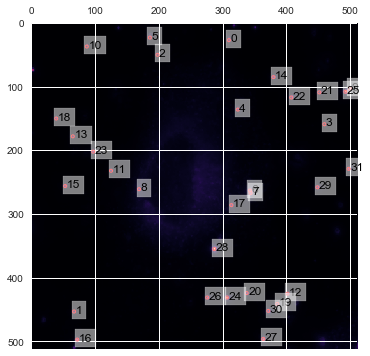

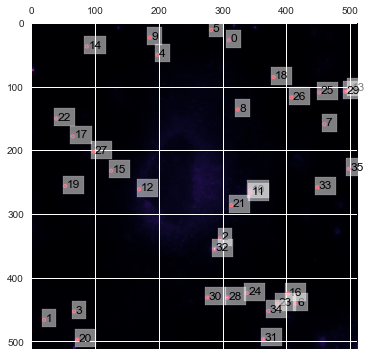

In [5]:
for k, p in psfs.items():
    p.peakfinder.find_blobs()
    p.peakfinder.remove_edge_blobs(10)
    p.peakfinder.plot_blobs(cmap="inferno")

In [6]:
%time f = p.fitPeaks(7, 12)

Wall time: 20.6 s


In [7]:
dict(zip((1, 2, 3), ("a", "b", "c")))

{1: 'a', 2: 'b', 3: 'c'}

In [8]:
p_wO = p.calc_psf_params(trim=1)
p_woO = p.calc_psf_params(trim=1, withoffset=False)

In [9]:
(p_wO - p_woO).dropna().z0 * 20

peak_num
1      237.778005
2     1194.136700
3        0.424150
4        0.846738
5        3.302922
6        3.399124
8       -0.631930
9     1134.180003
10    1104.663360
11       6.780177
13       3.415556
14      -0.363141
15      52.434494
16      60.788136
17       1.315125
18      -0.474103
19      -2.116568
20       2.656283
22       1.226970
23       1.154027
24      -0.522868
25      -0.466601
26      -0.609382
27      -0.319504
28       0.121608
29       2.919701
30       0.132730
31       0.929958
32      -1.159647
33       0.951135
34       0.265832
35      41.958368
Name: z0, dtype: float64

(<matplotlib.figure.Figure at 0x13d672c7b00>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000013D7832F898>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x0000013D79554400>]], dtype=object))

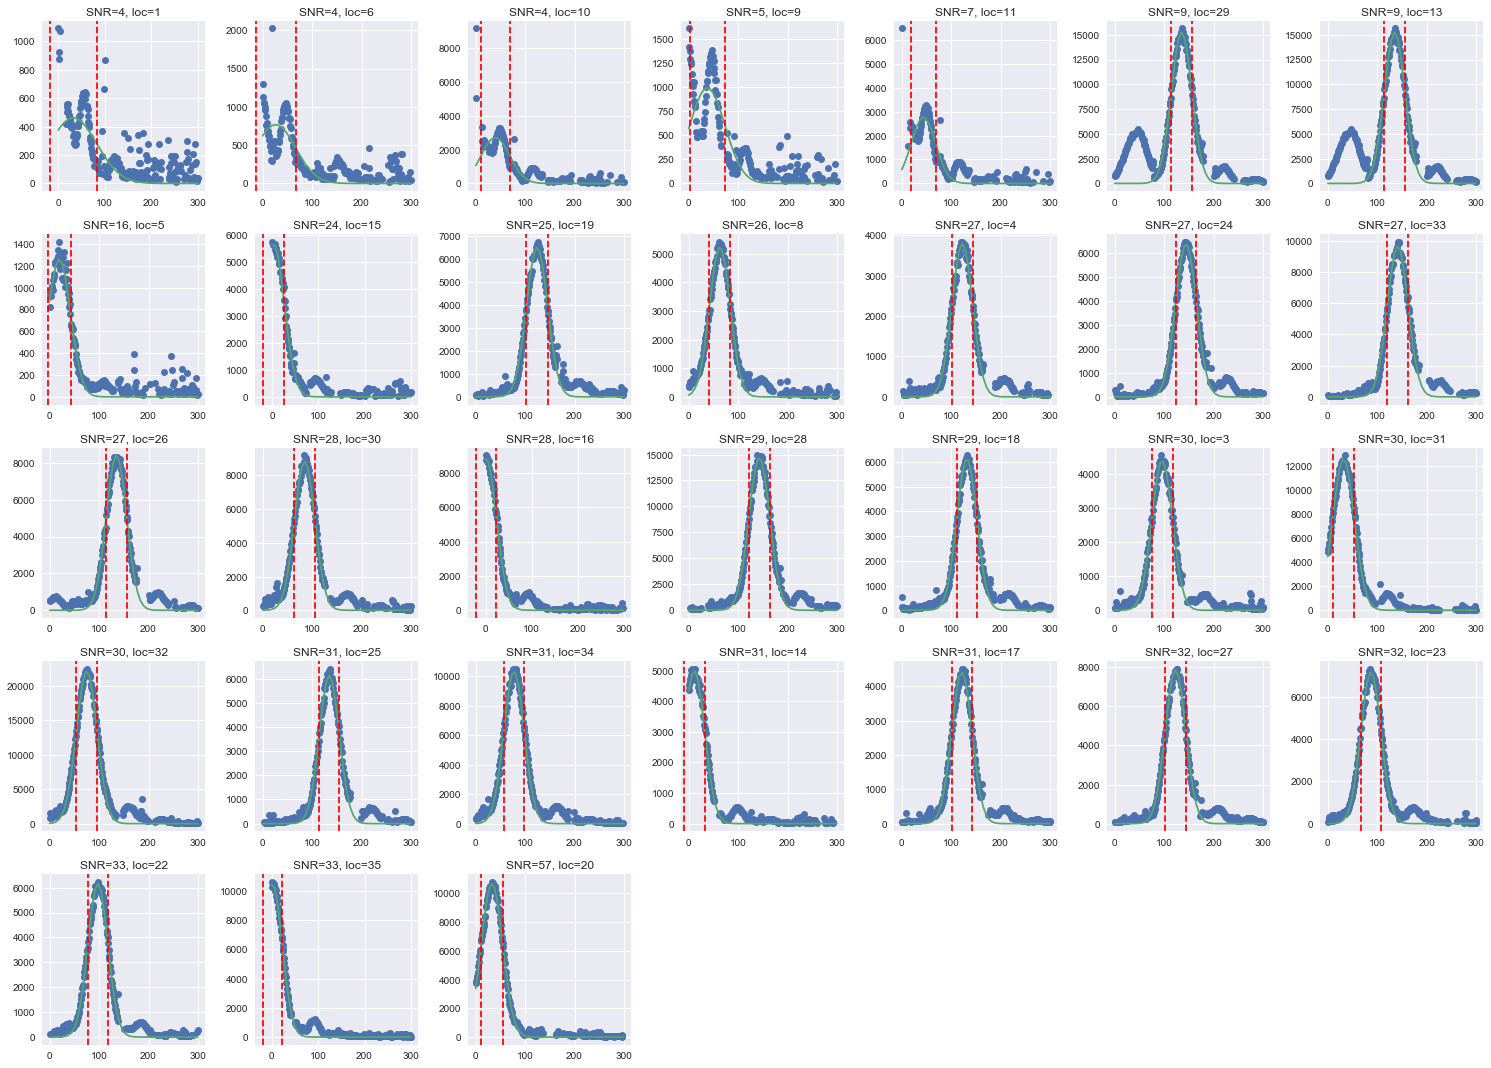

In [11]:
p.diagnostic_fits(-1, 1)

In [12]:
import tqdm

In [40]:
for k, p in tqdm.tqdm_notebook(psfs.items()):
    p.fits_dict = {}
    for method in tqdm.tqdm_notebook(("ls", "mle")):
        p.fits_dict[method] = {}
        for fitwin in tqdm.tqdm_notebook((8, 15, 19)):
            fits = p.fitPeaks(fitwin, 12, fittype=method)
            psf_params = p.calc_psf_params(trim=1, withoffset=False)
            p.fits_dict[method][fitwin] = dict(psf_params=psf_params, fits=fits)

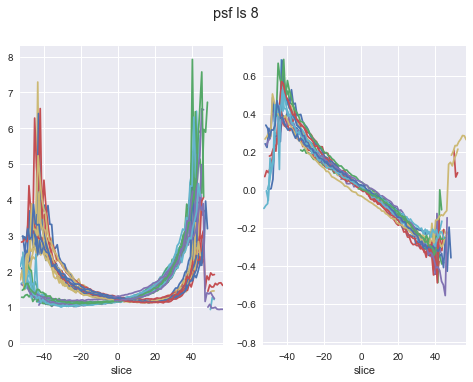

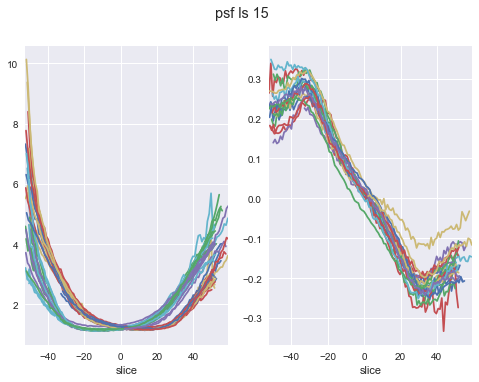

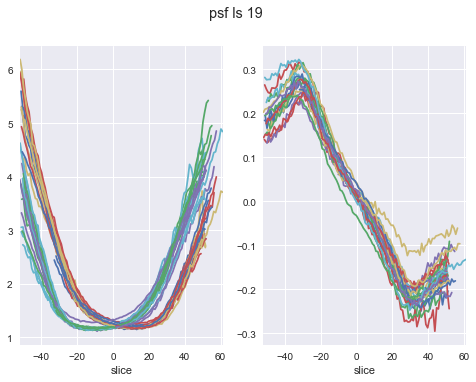

In [63]:
for k, p in tqdm.tqdm_notebook(psfs.items()):
    for method, win_d in sorted(p.fits_dict.items()):
        for fitwin, fit_dict in sorted(win_d.items()):
            fits = fit_dict["fits"]
            psf_params = fit_dict["psf_params"]
            fig, (ax0, ax1) = plt.subplots(1, 2)
            fig.suptitle("{} {} {}".format(k, method, fitwin))
            new_fits = []
            for i, param in psf_params.iterrows():
                if param.SNR > 25:
                    fit = fits[i].copy()
                    fit.index -= param.z0
                    num_frames = 2.5 * np.abs(param.sigma_z)
                    fit = fit[np.abs(fit.index) < num_frames]
                    if len(fit) > 0.8 * num_frames:
                        fit[["sigma_x", "sigma_y"]].plot(ax=ax0, legend=False)
                        fit["ellip"] = ((fit.sigma_x - fit.sigma_y)/(fit.sigma_x + fit.sigma_y))
                        fit.ellip.plot(ax=ax1, label=i)
                        new_fits.append(fit)
#                 break
#             break
            new_fits = pd.concat(new_fits)
        break
    break

In [68]:
new_fits = pd.concat(new_fits)

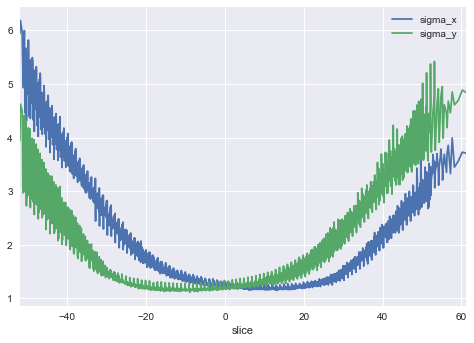

In [73]:
new_fits.sort_index()[["sigma_x", "sigma_y"]].plot()

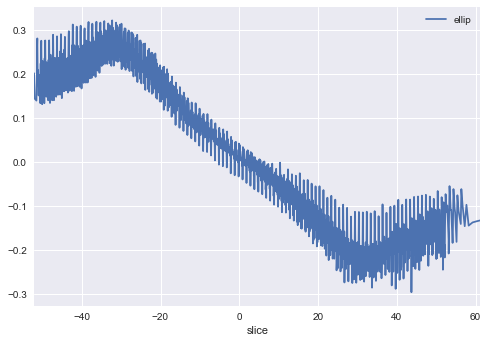

In [76]:
new_fits.sort_index()[["ellip"]].plot()

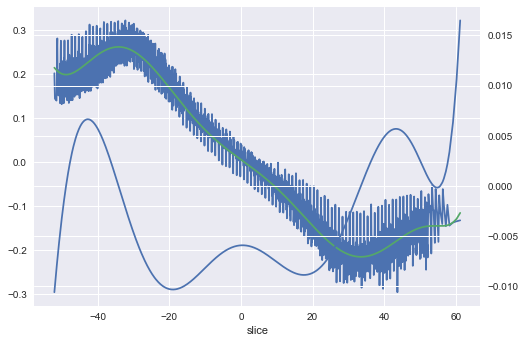

In [93]:
poly = np.poly1d(np.polyfit(new_fits.index, new_fits.ellip, 9, w=new_fits.amp))
new_fits.sort_index().ellip.plot()
plt.plot(new_fits.index.sort_values(), poly(new_fits.index.sort_values()))
plt.twinx().plot(new_fits.index.sort_values(), poly.deriv()(new_fits.index.sort_values()))

In [98]:
r = poly.deriv().roots

In [104]:
print(r[~np.iscomplex(r)])

[-77.55979461+0.j -48.82701530+0.j -34.18762270+0.j  55.64367014+0.j
  53.78521944+0.j  33.49381962+0.j]


In [111]:
def find_real_roots_near_zero(poly):
    r = poly.roots
    r = r[~np.iscomplex(r)].real
    r.sort()
    i = np.abs(r).argmin()
    r1 = r[i]
    if r1 < 0:
        return r[i:i + 2]
    else:
        return r[i - 1:i + 1]

In [163]:
poly.deriv()

poly1d([ -2.01397874e-15,   8.49164793e-14,   3.18947772e-12,
        -3.34179730e-10,  -3.37792726e-09,   4.12759847e-07,
         7.94668197e-06,   1.00191496e-04,  -4.79941972e-03])

In [159]:
from scipy import interpolate as interp

In [ ]:
interp.

In [161]:
for k, p in tqdm.tqdm_notebook(psfs.items()):
    for method, win_d in sorted(p.fits_dict.items()):
        for fitwin, fit_dict in sorted(win_d.items()):
            fits = fit_dict["fits"]
            psf_params = fit_dict["psf_params"]
            new_fits = []
            for i, param in psf_params.iterrows():
                if param.SNR > 25:
                    num_frames = 2 * np.abs(param.sigma_z)
                    fit = fits[i].copy()
                    # shift index
                    fit.index -= param.z0
#                     fit = fit[np.abs(fit.index) < num_frames]
                    fit[["x0", "y0"]] -= fit[["x0", "y0"]][np.abs(fit.index) < num_frames].mean()
                    fit["ellip"] = ((fit.sigma_x - fit.sigma_y)/(fit.sigma_x + fit.sigma_y))
                    new_fits.append(fit)
            # put corrected fits into dict
            fit_dict["corrected_fits"] = pd.concat(new_fits).sort_index()

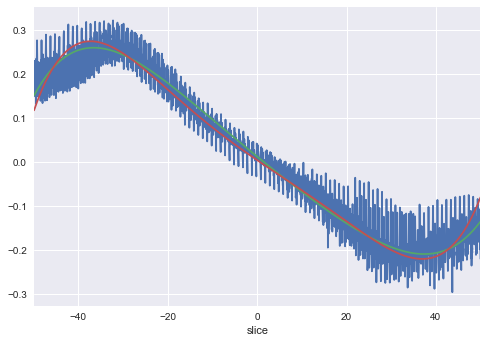

In [172]:
for k in ("ellip",):# "x0", "y0", "sigma_x", "sigma_y"):
    v = fit_dict["corrected_fits"]
    v = v[np.abs(v.index) < 50]
    polys = [np.poly1d(np.polyfit(v.index, v[k], 5, w=w)) for w in [None, v.amp]]
    fig, ax = plt.subplots()
    v[k].plot(ax=ax)
    for poly in polys:
        ax.plot(v.index, poly(v.index))

In [174]:
%timeit find_real_roots_near_zero(poly)

92.5 µs ± 251 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
